In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch

# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))

Is CUDA available?  True
Device name:  Tesla T4


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-05-20 02:24:58.380658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747707898.604135      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747707898.682900      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 20

In [2]:
TRAIN_DIR = '../input/gender-classification-dataset/Training'
VALIDATION_DIR = '../input/gender-classification-dataset/Validation'

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Class mapping: {train_generator.class_indices}")

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Class mapping: {'female': 0, 'male': 1}


In [10]:
steps_per_epoch = len(train_generator) // BATCH_SIZE
validation_steps = len(validation_generator) // BATCH_SIZE

In [ ]:
def create_resnet_model():
    
    base_model = ResNet50(
        weights='imagenet',  
        include_top=False,   
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    for layer in base_model.layers[-20:]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification (male/female)
    ])
    
    return model


resnet_model = create_resnet_model()

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 14,873,857 (56.74 MB)

 Non-trainable params: 8,984,448 (34.27 MB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='resnet50_gender_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7479 - loss: 0.4963
Epoch 1: val_accuracy improved from -inf to 0.98889, saving model to resnet50_gender_model.h5
183/183 ━━━━━━━━━━━━━━━━━━━━ 110s 243ms/step - accuracy: 0.7484 - loss: 0.4955 - val_accuracy: 0.9889 - val_loss: 0.0279 - learning_rate: 1.0000e-04
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9135 - loss: 0.2388
Epoch 2: val_accuracy did not improve from 0.98889
183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.9135 - loss: 0.2386 - val_accuracy: 0.9806 - val_loss: 0.0685 - learning_rate: 1.0000e-04
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9385 - loss: 0.1672
Epoch 3: val_accuracy did not improve from 0.98889
183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - accuracy: 0.9384 - loss: 0.1672 - val_accuracy: 0.9792 - val_loss: 0.0485 - learning_rate: 1.0000e-04
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9407 - loss: 0.1715
Epoch 4

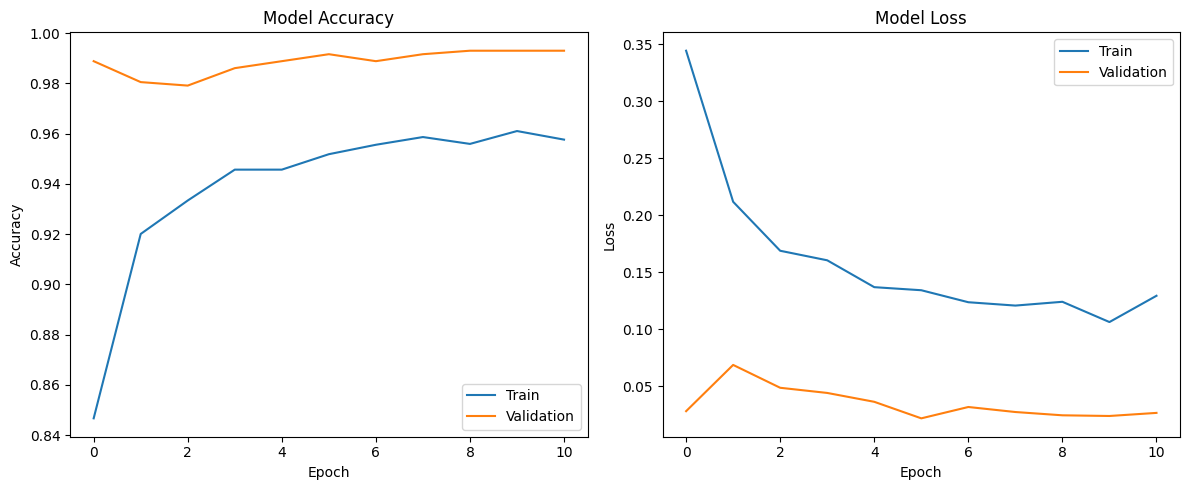

In [20]:
# Plot training history
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Function to predict gender from a custom image
def predict_custom_image(model, image_path, class_indices):
    """
    Predict gender from a custom image path
    
    Parameters:
    -----------
    model : Keras model
        Trained model for gender detection
    image_path : str
        Path to the image file
    class_indices : dict
        Dictionary mapping class indices to class names
        
    Returns:
    --------
    None, displays the image with prediction
    """
    # Load and preprocess the image
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Apply the same preprocessing as used during training
        img_array = preprocess_input(img_array)
        
        # Make prediction
        prediction = model.predict(img_array, verbose=0)[0][0]
        
        # Get class names
        class_names = list(class_indices.keys())
        
        # Determine predicted class and confidence
        pred_class = class_names[1] if prediction > 0.5 else class_names[0]
        confidence = prediction if prediction > 0.5 else 1 - prediction
        
        # Display the image with prediction
        plt.figure(figsize=(8, 8))
        img = tf.keras.preprocessing.image.load_img(image_path)
        plt.imshow(img)
        plt.axis('off')
        
        plt.title(f"Prediction: {pred_class.capitalize()} (Confidence: {confidence:.2f})", 
                 fontsize=16, color='blue')
        
        # Additional prediction details
        gender_probs = {
            class_names[0]: 1 - prediction,
            class_names[1]: prediction
        }
        
        # Add a text box with probabilities
        textstr = '\n'.join([
            f"{gender.capitalize()}: {prob:.2f}" 
            for gender, prob in gender_probs.items()
        ])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.figtext(0.15, 0.15, textstr, fontsize=14,
                  verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.show()
        
        return pred_class, confidence
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Example usage - replace with your own image path
# Provide a UI for image selection
from ipywidgets import interact, widgets

@interact
def predict_image(image_path=widgets.Text(
    value='',
    placeholder='Enter the full path to an image file',
    description='Image Path:',
    disabled=False,
    style={'description_width': 'initial'}
)):
    if image_path:
        try:
            pred_class, confidence = predict_custom_image(
                resnet_model, 
                image_path, 
                validation_generator.class_indices
            )
            if pred_class and confidence:
                print(f"\nPrediction: {pred_class.capitalize()} with {confidence:.2%} confidence")
        except Exception as e:
            print(f"Error: {e}")
    else:
        print("Please enter a valid image path")

# Alternative direct usage without widgets
# Replace with the path to your image
# Example:
# predict_custom_image(resnet_model, "path/to/your/image.jpg", validation_generator.class_indices)

interactive(children=(Text(value='', description='Image Path:', placeholder='Enter the full path to an image f…